<a href="https://colab.research.google.com/github/heejvely/NLP_models/blob/main/Transformer_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Vocab

sentencepiece를 활용해 만든 vocab을 이용해 텍스트를 입력 tensor로 변경

In [1]:
# sentencepiece import
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [4]:
import sentencepiece as spm
# vocab loading
vocab_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

* SentencePieceProcessor class 참고
: https://github.com/google/sentencepiece/blob/master/doc/api.md

In [5]:
help(spm.SentencePieceProcessor)

Help on class SentencePieceProcessor in module sentencepiece:

class SentencePieceProcessor(builtins.object)
 |  SentencePieceProcessor(model_file=None, model_proto=None, out_type=<class 'int'>, add_bos=False, add_eos=False, reverse=False, enable_sampling=False, nbest_size=-1, alpha=0.1)
 |  
 |  Methods defined here:
 |  
 |  Decode(self, input)
 |      Decode processed id or token sequences.
 |  
 |  DecodeIds = DecodeIdsWithCheck(self, ids)
 |  
 |  DecodeIdsAsSerializedProto = DecodeIdsAsSerializedProtoWithCheck(self, ids)
 |  
 |  DecodeIdsAsSerializedProtoWithCheck(self, ids)
 |  
 |  DecodeIdsWithCheck(self, ids)
 |  
 |  DecodePieces(self, pieces)
 |  
 |  DecodePiecesAsSerializedProto(self, pieces)
 |  
 |  Detokenize = Decode(self, input)
 |  
 |  Encode(self, input, out_type=None, add_bos=None, add_eos=None, reverse=None, enable_sampling=None, nbest_size=None, alpha=None)
 |      Encode text input to segmented ids or tokens.
 |      
 |      Args:
 |      input: input string

In [10]:
# 입력 texts
lines = [
         '겨울은 추워요',
         '감기 조심하세요.'
         ]

import torch
# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맞춰 padding(0)을 추가해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first = True, padding_value=0)

# shape
print(inputs.size())

# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3215, 3556,  197, 3908, 3712,    0,    0,    0],
        [ 200, 3558,   53, 3785, 3548, 3636, 3712, 3542]])


2. Embedding

Transformer의 Embedding은 'Input Embedding'과 'Position Embedding' 두 가지를 합해서 사용

In [17]:
# Input Embedding
import torch.nn as nn

n_vocab = len(vocab)  # vocab count
d_hidn = 128          # hidden size
nn_emb = nn.Embedding(n_vocab,d_hidn) # embedding 객체

input_embs = nn_emb(inputs)   # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


In [20]:
# Position Embedding
import numpy as np

""" sinusoid position embedding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position, i_hidn):                                              # 각 position별 angle값 구함
    return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq) ])
  sinusoid_table[:,0::2] = np.sin(sinusoid_table[:,0::2])     # dim 2i          # angle 중 짝수 index의 값에 대한 sin값 구함
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:,1::2])     # dim 2i+1       # angle 중 홀수 index의 값에 대한 cos값 구함

  return sinusoid_table

(64, 128)


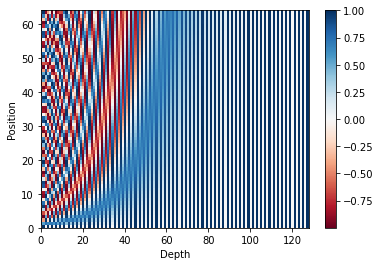

In [22]:
import matplotlib.pyplot as plt

n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim(0, d_hidn)
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 포지션 별로 다른 값을 가짐.

In [23]:
pos_encoding = torch.FloatTensor(pos_encoding)                        # position encoding 값 구함
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)      # position embedding 생성, 학습 되는 값이 아니기 때문에 freeze True

# 입력 inputs 값과 동일한 크기를 갖는 positions 값 구하기
positions = torch.arange(inputs.size(1), device = inputs.device, dtype = inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous()+1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask,0)    # positions 값 중 pad 부분은 0으로 변경
pos_embs = nn_pos(positions)          # positions 값에 해당하는 embedding 값을 구함.

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3215, 3556,  197, 3908, 3712,    0,    0,    0],
        [ 200, 3558,   53, 3785, 3548, 3636, 3712, 3542]])
tensor([[1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [26]:
input_sums = input_embs + pos_embs

3. Scaled Dot Product Attention

- 입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성
- 입력값 중 K, V는 같은 값이어야 함.

In [29]:
# Input
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

# pad(0) 부분만 True

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True]])


In [30]:
# Q*K-transpose
scores = torch.matmul(Q, K.transpose(-1,-2))
print(scores.size())
print(scores[0])

# 각 단어 상호간에 가중치를 표현

torch.Size([2, 8, 8])
tensor([[225.5586,  53.1667,  62.8387,  63.5019,  69.2988,  90.1714,  90.1714,
          90.1714],
        [ 53.1667, 140.2915,  44.8861,  50.2730,  49.8239,  37.5278,  37.5278,
          37.5278],
        [ 62.8387,  44.8861, 176.3021,  62.6111,  67.8105,  51.3912,  51.3912,
          51.3912],
        [ 63.5019,  50.2730,  62.6111, 175.5244,  68.3339,  60.8716,  60.8716,
          60.8716],
        [ 69.2988,  49.8239,  67.8105,  68.3339, 213.8883,  46.9329,  46.9329,
          46.9329],
        [ 90.1714,  37.5278,  51.3912,  60.8716,  46.9329, 207.6588, 207.6588,
         207.6588],
        [ 90.1714,  37.5278,  51.3912,  60.8716,  46.9329, 207.6588, 207.6588,
         207.6588],
        [ 90.1714,  37.5278,  51.3912,  60.8716,  46.9329, 207.6588, 207.6588,
         207.6588]], grad_fn=<SelectBackward0>)


In [31]:
# Scale
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

# dimension에 루트를 취한 값으로 ㄴ눔. 가중치 편차가 줄어듦.

torch.Size([2, 8, 8])
tensor([[28.1948,  6.6458,  7.8548,  7.9377,  8.6624, 11.2714, 11.2714, 11.2714],
        [ 6.6458, 17.5364,  5.6108,  6.2841,  6.2280,  4.6910,  4.6910,  4.6910],
        [ 7.8548,  5.6108, 22.0378,  7.8264,  8.4763,  6.4239,  6.4239,  6.4239],
        [ 7.9377,  6.2841,  7.8264, 21.9405,  8.5417,  7.6090,  7.6090,  7.6090],
        [ 8.6624,  6.2280,  8.4763,  8.5417, 26.7360,  5.8666,  5.8666,  5.8666],
        [11.2714,  4.6910,  6.4239,  7.6090,  5.8666, 25.9574, 25.9574, 25.9574],
        [11.2714,  4.6910,  6.4239,  7.6090,  5.8666, 25.9574, 25.9574, 25.9574],
        [11.2714,  4.6910,  6.4239,  7.6090,  5.8666, 25.9574, 25.9574, 25.9574]],
       grad_fn=<SelectBackward0>)


In [33]:
# Mask(Opt.)
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

# mask를 한 부분이 -1e9로 매우 작은 값으로 변경됨.

torch.Size([2, 8, 8])
tensor([[ 2.8195e+01,  6.6458e+00,  7.8548e+00,  7.9377e+00,  8.6624e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 6.6458e+00,  1.7536e+01,  5.6108e+00,  6.2841e+00,  6.2280e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 7.8548e+00,  5.6108e+00,  2.2038e+01,  7.8264e+00,  8.4763e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 7.9377e+00,  6.2841e+00,  7.8264e+00,  2.1941e+01,  8.5417e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 8.6624e+00,  6.2280e+00,  8.4763e+00,  8.5417e+00,  2.6736e+01,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 1.1271e+01,  4.6910e+00,  6.4239e+00,  7.6090e+00,  5.8666e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 1.1271e+01,  4.6910e+00,  6.4239e+00,  7.6090e+00,  5.8666e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 1.1271e+01,  4.6910e+00,  6.4239e+00,  7.6090e+00,  5.8666e+00,
         -1.0000e+09, -1.0000e+09, -1.0000e

In [34]:
# Softmax
attn_prob = nn.Softmax(dim= -1)(scores)
print(attn_prob.size())
print(attn_prob[0])

# 가중치가 확률로 변환된 값을 확인 mask 한 부분은 0이 됨.

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 4.3792e-10, 1.4671e-09, 1.5939e-09, 3.2897e-09, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.8632e-05, 9.9995e-01, 6.6179e-06, 1.2976e-05, 1.2268e-05, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [6.9252e-07, 7.3425e-08, 1.0000e+00, 6.7310e-07, 1.2892e-06, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.2919e-07, 1.5867e-07, 7.4182e-07, 1.0000e+00, 1.5169e-06, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4148e-08, 1.2401e-09, 1.1746e-08, 1.2541e-08, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.6209e-01, 1.3346e-03, 7.5503e-03, 2.4696e-02, 4.3245e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.6209e-01, 1.3346e-03, 7.5503e-03, 2.4696e-02, 4.3245e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.6209e-01, 1.3346e-03, 7.5503e-03, 2.4696e-02, 4.3245e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward0>)


In [35]:
# atten_prov * V
context = torch.matmul(attn_prob,V)
print(context.size())

# Q와 동일한 shape의 값이 구해짐.

torch.Size([2, 8, 128])


In [42]:
# 위 절차를 하나의 Class로 구성

"""scale dot product attention"""

class ScaledDotProductAttention(nn.Module):
  def __init__(self, d_head):
    super().__init__()
    self.scale = 1 / (d_head ** 0.5)

  def forward(self, Q, K, V, attn_mask):
    # (bs, n_head, n_q_seq, n_k_seq)
    scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
    scores.masked_fill_(attn_mask, -1e9)
    attn_prob = nn.Softmax(dim= -1)(scores)
    context = torch.matmul(attn_prob, V)
    return context, attn_prob

4. Multi-Head Attention

- Q, K, V, attn_mask는 ScaledDotProductAttention과 동일
- head개수는 2개, head의 dimension은 64

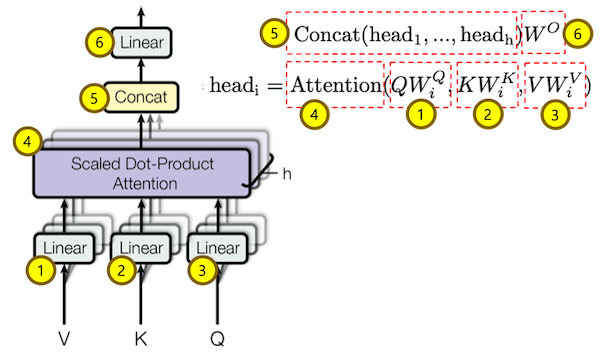

In [37]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

In [38]:
# Multi Head Q, K, V
# Q를 여러개의 head로 나누는 과정

W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [39]:
# 위 과정을 한 줄로 표현
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


In [40]:
# Attention Mask Multi Head로 변경
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


In [43]:
# Attention

scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


In [45]:
# Concat
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


In [46]:
# Linear
linear = nn.Linear(n_head * d_head, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


In [47]:
# 위 절차를 하나의 Class로 구성

"""multi head attention"""
class MultiHeadAttention(nn.Module):
  def __init__(self, d_hidn, n_head, d_head):
    super().__init__()
    self.d_hidn = d_hidn
    self.n_head = n_head
    self.d_head = d_head

    self.W_Q = nn.Linear(d_hidn, n_head * d_head)
    self.W_K = nn.Linear(d_hidn, n_head * d_head)
    self.W_V = nn.Linear(d_hidn, n_head * d_head)
    self.scaled_dot_attn = ScaledDotProductAttention(d_head)
    self.linear = nn.Linear(n_head * d_head, d_hidn)

  def forward(self, Q, K, V, attn_mask):
    batch_size = Q.size(0)
    q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
    k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
    v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)
    context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
    output = self.linear(context)
    
    return output, attn_prob

5. Masked Multi-Head Attention

Masked Multi-Head Attention은 Multi-Head Attention과 attention mask를 제외한 부분 모두 동일

In [49]:
"""attention decoder mask"""
def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
  subsequent_mask = subsequent_mask.triu(diagonal=1)  # upper triangular part of a matrix(2-D)
  return subsequent_mask

Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


In [50]:
# Multi-Head Attention
# Multi-Head Attention과 동일하므로 위에서 선언한 클래스 바로 호출

attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


6. FeedForward

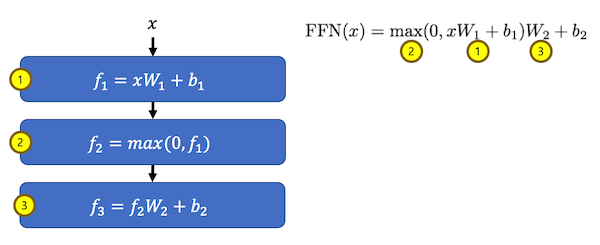

In [51]:
# 1번 f1(Linear) 과정
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

# 입력에 비해 hidden dimension이 4배 커짐

torch.Size([2, 512, 8])


논문이 발표 될 당시는 relu를 사용하도록 되어 있었지만, 이후 gelu를 사용할 때 더 성능이 좋다는 것이 발견되었음.

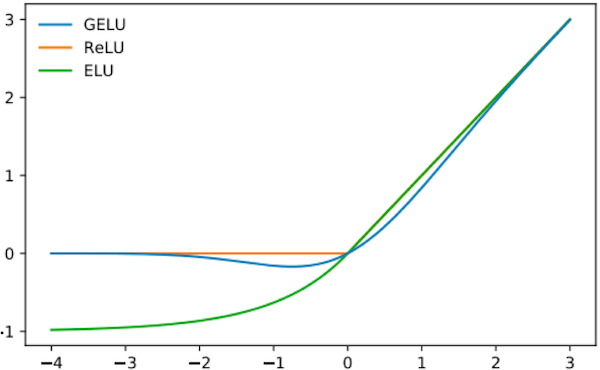

In [54]:
# Activation(relu or gelu)
import torch.nn.functional as F

active = F.gelu
ff_2 = active(ff_1)

In [55]:
# f3(Linear)

conv2 = nn.Conv1d(in_channels = d_hidn * 4, out_channels = d_hidn, kernel_size = 1)
ff_3 = conv2(ff_2).transpose(1,2)
print(ff_3.size())

# 입력과 동일한 shape으로 변경

torch.Size([2, 8, 128])


In [56]:
# 위 절차를 하나의 클래스 형태로 구성

"""feed forward"""
class PoswiseFeedForwardNet(nn.Module):
  def __init__(self, d_hidn):
    super().__init__()

    self.conv1 = nn.Conv1d(in_channels = self.config.d_hidn, out_channels = self.config.d_hidn * 4, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels = self.config.d_hidn * 4, out_channels = self.config.d_hidn, kernel_size=1)
    self.active = F.gelu

  def forward(self, inputs):
    output = self.active(self.conv1(inputs.transpose(1,2)))
    output = self.conv2(output).transpose(1, 2)
    return output